## WDL -- Finals
### Improving the quality of life by reducing city noise levels

### Introduction

Nowadays, we live faster, more intensively, running back and forth... and also more noisily. We travel, we socilize, we meet people and we spend a lot of time making different outdoor activities. Obviously it has its consequencies, as everything, in this case, harming the neighbours. 

On the other hand, everyday health is more and more important in our lifes. We measure our blood pressure, diabetes and cholesterol. We analyse deeper and we discover new causes which provoke new deseases. Here, in this repository we analyse a quite harmful, unvisible and unknown aspect which disrupts silently our health. The noise.

Noise pollution is the propagation of noise with ranging impacts on the activity of human or animal life. Some of the main sources of noise in residential areas include loud music, transportation (traffic, rail, airplanes, etc.), construction, electrical generators and people. The last one has increased in the last years, especially in the main old cities across Europe.

Today we analyse Torino (Piemonte, Italy). Authorities have installed a series of noise sensors in order to quantify the decibels and qualify the environmental noise. The project started in 2016. The target area of the city is the historic center of San Salvario because of its active night life. This is one of the strength of the project, the good location of the sensors. On the other hand, there are some improvements points in terms of data mining.

During the repository we will tackle the main characteristics of the problem, such as, its reasons and consequencies. And we will propose some measures and actions to take into account in order to improve the project working and residents sleep.

### Data Collection

In [72]:
import pandas as pd
import glob
import shapefile
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pandas_profiling import ProfileReport

#!pip install statsmodels==0.12.1
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima_model import ARIMA
from itertools import product

from scipy.stats import levene, shapiro

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import mannwhitneyu

In [88]:
# import datapresence and SIM_count
path = r'C:\Users\bvazq\Desktop\juegos\9-WDL\Finals\Data\sim_count\SIM Count - 20200430 - 20200615'
all_files = glob.glob(path + "\*.csv")

path2 = r'C:\Users\bvazq\Desktop\juegos\9-WDL\Finals\Data\sim_count\SIM Count - 20210430 - 20210615'
all_files2 = glob.glob(path2 + "\*.csv")

path3 = r'C:\Users\bvazq\Desktop\juegos\9-WDL\Finals\Data\sim_count'
all_files3 = glob.glob(path3 + "\*.csv")

dfs = list()
frame = pd.DataFrame([])
for filename in all_files:    
    df = pd.read_csv(filename, sep = ';')  
    dfs.append(df)

frame = pd.concat(dfs, axis=0, ignore_index=True)

dfs = list()
frame2 = pd.DataFrame([])
for filename in all_files2:    
    df = pd.read_csv(filename, sep = ';')  
    dfs.append(df)

frame2 = pd.concat(dfs, axis=0, ignore_index=True)

dfs = list()
for filename in all_files3:    
    df = pd.read_csv(filename, sep = ';')  
    dfs.append(df)

frame3 = pd.concat(dfs, axis=0, ignore_index=True)

In [89]:
base = frame.pivot(index='datefrom', columns = 'datatype', values = 'datavalue')
base.columns = ['1.- <18','2.- 18 - 30','3.- 31 - 40','4.- 41 - 50','5.- 51 - 60','6.- >60','Woman','Man','Italian','Foreigner','Presence Human','Presence','Business','Consumer','Extraregional visitor','Intraregional visitor','Commuters','Residents','Foreigner visitor']

base2 = frame2.pivot(index='datefrom', columns = 'datatype', values = 'datavalue')
base2.columns = ['1.- <18','2.- 18 - 30','3.- 31 - 40','4.- 41 - 50','5.- 51 - 60','6.- >60','Woman','Man','Italian','Foreigner','Presence Human','Presence','Business','Consumer','Extraregional visitor','Intraregional visitor','Commuters','Residents','Foreigner visitor']

base3 = frame3.pivot(index='data_da', columns = 'cluster', values = 'numero_presenze')


In [90]:
# people streets presence
presence = pd.concat([base,base2]).reset_index()

presence['visitors'] = presence['Presence'] - presence['Residents']
presence['visitors_%'] = (100 * presence['visitors'] / presence['Presence']).round(2)

presence['year'] = pd.to_datetime(presence['datefrom']).dt.strftime('%Y')
presence['data'] = pd.to_datetime(presence['datefrom']).dt.strftime('%d-%m-%Y')
presence['data2'] = pd.to_datetime(presence['data'], dayfirst = True)#.dt.strftime('%d-%m-%Y')
presence['hour'] = pd.to_datetime(presence['datefrom']).dt.strftime('%H').astype(int)

presence['weekday0'] = pd.to_datetime(presence['datefrom']).dt.dayofweek.astype(int)
presence.loc[presence['weekday0'] <= 3, 'week_period'] = 'midweek' # monday, thursday, wednesday, tuesday
presence.loc[presence['weekday0'] > 3, 'week_period'] = 'weekend'

presence.loc[presence['hour'].between(6,13, inclusive = True), 'day_period'] = 'morning'
presence.loc[presence['hour'].between(14,21, inclusive = True), 'day_period'] = 'afternoon'
presence.loc[22 <= presence['hour'] , 'day_period'] = 'evening'
presence.loc[presence['hour'] < 6 , 'day_period'] = 'evening'

presence['young'] = presence['1.- <18'] + presence['2.- 18 - 30']
presence['midage'] = presence['3.- 31 - 40'] + presence['4.- 41 - 50']
presence['oldage'] = presence['5.- 51 - 60'] + presence['6.- >60']

presence = presence[['datefrom','1.- <18','2.- 18 - 30','3.- 31 - 40','4.- 41 - 50','5.- 51 - 60','6.- >60','Woman','Man','Italian',
          'Foreigner','Presence Human','Presence','Business','Consumer','Extraregional visitor','Intraregional visitor',
          'Commuters','Residents','Foreigner visitor','visitors','visitors_%','year','data','data2','hour','weekday0','week_period',
          'day_period','young','midage','oldage']]
presence.head(5)

,datefrom,1.- <18,2.- 18 - 30,3.- 31 - 40,4.- 41 - 50,5.- 51 - 60,6.- >60,Woman,Man,Italian,...,year,data,data2,hour,weekday0,week_period,day_period,young,midage,oldage
0,2020-04-30 22:00:00,248.0,4114.0,3368.0,4256.0,4949.0,10268.0,13227.0,13977.0,32160.0,...,2020,30-04-2020,2020-04-30,22,3,midweek,evening,4362.0,7624.0,15217.0
1,2020-04-30 23:00:00,242.0,4125.0,3339.0,4247.0,4919.0,10220.0,13213.0,13879.0,32068.0,...,2020,30-04-2020,2020-04-30,23,3,midweek,evening,4367.0,7586.0,15139.0
2,2020-05-01 00:00:00,241.0,4075.0,3298.0,4207.0,4861.0,10115.0,13063.0,13734.0,31728.0,...,2020,01-05-2020,2020-05-01,0,4,weekend,evening,4316.0,7505.0,14976.0
3,2020-05-01 01:00:00,242.0,4033.0,3273.0,4164.0,4796.0,10005.0,12925.0,13588.0,31399.0,...,2020,01-05-2020,2020-05-01,1,4,weekend,evening,4275.0,7437.0,14801.0
4,2020-05-01 02:00:00,241.0,4009.0,3275.0,4126.0,4738.0,9846.0,12766.0,13470.0,31071.0,...,2020,01-05-2020,2020-05-01,2,4,weekend,evening,4250.0,7401.0,14584.0


In [93]:
# Acustic Sensor information
path4 = r'C:\Users\bvazq\Desktop\juegos\9-WDL\Finals\Data\noise_data\san_salvarino'
all_files4 = glob.glob(path4 + "\*.csv")

dfs = list()

for filename in all_files4:    
    df = pd.read_csv(filename, sep = ';')
    dfs.append(df)
    
noise = pd.concat(dfs, axis=0, ignore_index=True)

noise['Data2'] = pd.to_datetime(noise['Data'], dayfirst = True)
noise['year'] = pd.to_datetime(noise['Data'], dayfirst = True).dt.strftime('%Y')
noise['month'] = pd.to_datetime(noise['Data'], dayfirst = True).dt.strftime('%m')
noise['hour'] = pd.to_datetime(noise['Ora'], dayfirst = True).dt.strftime('%H').astype(int)
noise.head(5)

,Data,Ora,C1,C2,C3,C4,C5,Data2,year,month,hour
0,01/06/2016,0:00,61.1,58.8,63.7,60.4,60.2,2016-06-01,2016,06,0
1,01/06/2016,1:00,57.2,56.1,60.4,57.7,58.4,2016-06-01,2016,06,1
2,01/06/2016,2:00,52.5,53.4,52.9,56.7,56.5,2016-06-01,2016,06,2
3,01/06/2016,3:00,50.6,46.6,45.7,47.9,55.6,2016-06-01,2016,06,3
4,01/06/2016,4:00,47.4,46.2,45.1,45.8,56.8,2016-06-01,2016,06,4


In [ ]:
# finally we join noise sensor with presence information
noise2 = noise[[ 'C1', 'C2', 'C3', 'C4', 'C5','hour', 'Data2']]
noise_presence = presence.merge(noise2, left_on = ['data2','hour'], right_on = ['Data2','hour'])
noise_presence = noise_presence[['datefrom', '1.- <18', '2.- 18 - 30', '3.- 31 - 40', '4.- 41 - 50',
       '5.- 51 - 60', '6.- >60', 'Woman', 'Man', 'Italian', 'Foreigner',
       'Presence Human', 'Presence', 'Business', 'Consumer',
       'Extraregional visitor', 'Intraregional visitor', 'Commuters',
       'Residents', 'Foreigner visitor','visitors','visitors_%', 'year', 'data2', 'hour',
       'weekday0', 'week_period', 'day_period', 'young', 'midage', 'oldage',
       'C1', 'C2', 'C3']] 
noise_presence

### Noise pollution detection -- EDA 

One of the main strenghts of the data mining system is the location of the sensors. Installed in the historic center of one of the most frequented neighborhoods of Torino, especially in the night, San Salvario. These sensors allow us analyse if acustic pollution take peaks in the night, when silence is more needed. 


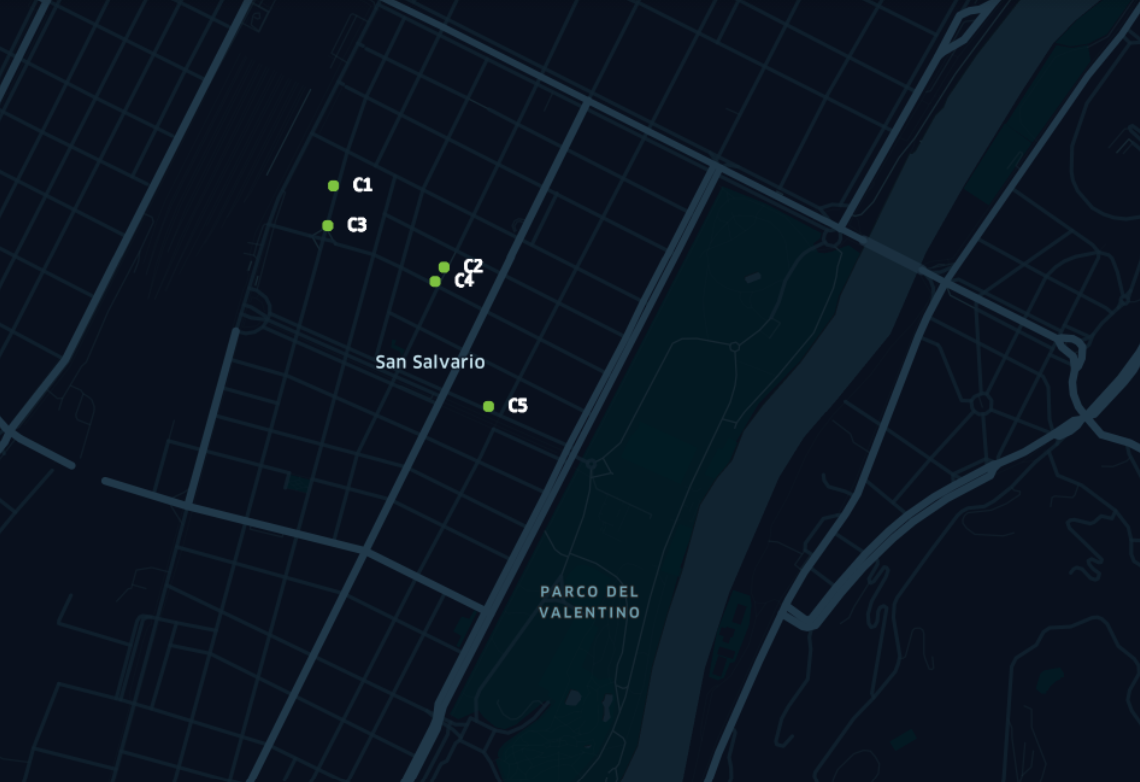


As we can see in the graph below, where we show the frequency of decibel levels by hour of the day, from 20h the most part of the days C3 levels exceed 60 dB or even 70 dB, untill 3h or 4h in the morning, when dB achieve the lowest levels. This sensor is located in Largo Saluzzo where a lot of people meet to enjoy the night.

If reader wants to analyse HTML can download here: https://drive.google.com/file/d/1_BmiedyVgvJN8PlVa95w5R2hi0hbYSIw/view?usp=sharing

In [ ]:
profile = ProfileReport(noise, title="Pandas Profiling Report: noise")
profile.to_file("noise.html")

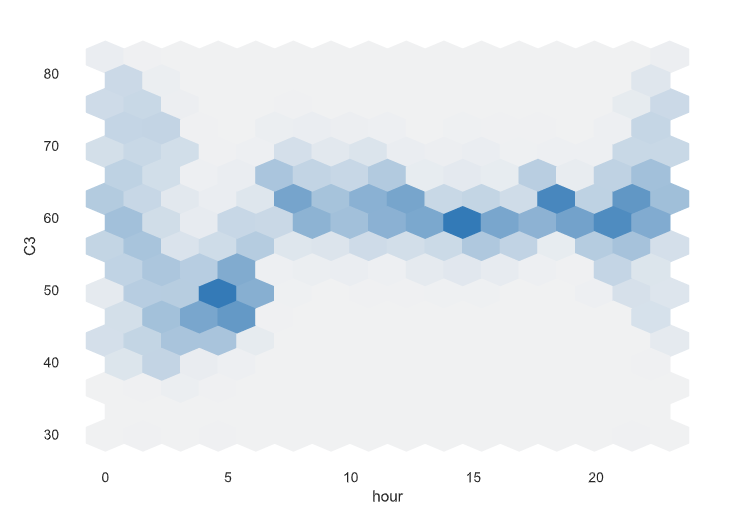

Focusing this time in day of the week we can conclude that the higher levels of noise pollution are achieved in weekends (Days 4, 5 and 6 which stands to friday, saturday and sunday)

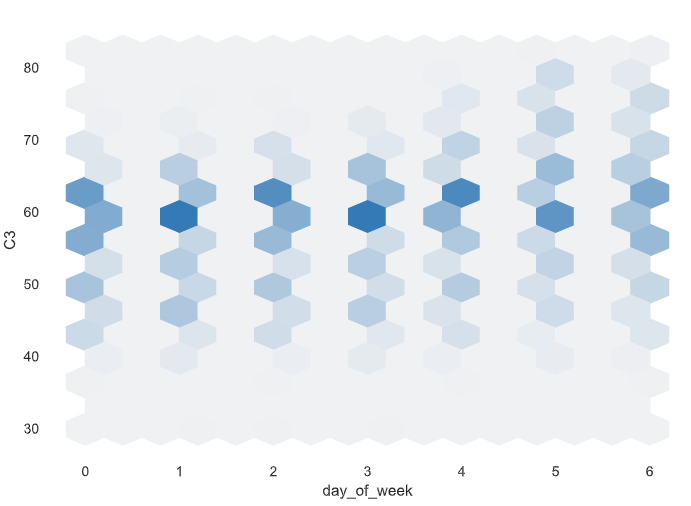

But the behaviour it is not the same for every sensor. In the next chart we have the same kind of information but collected by sensor C2. Noise levels in this area are both lower and more linear. This sensor is located in Via Principe Tommaso.

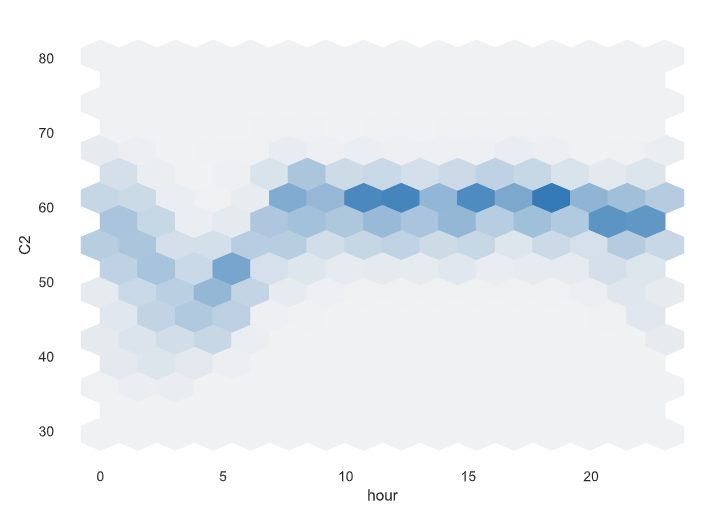

### Noise pollution detection -- Analysis of sensor missing values

In the improvements points section we would like to remark sensors missing values. As we show in the next graph.

Starting from above, white areas represent the missing values. So, C1 and C2 sensors work quite well. Nevertheless, sensors C3, C4 and C5 show blank zones. Especialy C4 and C5 which have in the middle of the series an extensive time lapse without information. That could be because of machine breackdowns. Also we can see that C4 and C5 failures are strongly related. On the other hand, the number of C3 fails is higher than the others sensors but shorterly.  

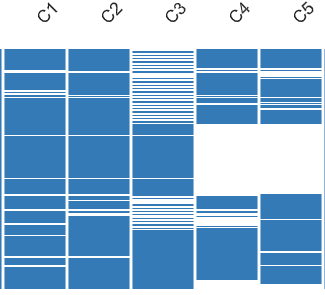

It is very important to have robust data. If not, Data scientist can not monitor what is happening in the streets, develope good models, which predict peaks of noise, and to show alerts when decibel levels are too high. 

### Police complaints analysis

As it is normal, when residents are upset because of the noise during their sleeps they make a police complaint, informing about the situation near their residences. All these data are stored in a database which we analyse in order to predict future complaints, helping manage the situation to the police.



In [ ]:
#2016
police_complains_JanJun16=pd.read_csv('police_complaints/OpenDataContact_Gennaio_Giugno_2016.csv')
police_complains_JulDec16=pd.read_csv('police_complaints/Contact_Luglio_Dicembre_2016.csv')
#2017
police_complains_JanJun17=pd.read_csv('police_complaints/Contact_Gennaio_Giugno_2017.csv')
police_complains_JulDec17=pd.read_csv('police_complaints/OpenDataContact_Luglio_Dicembre_2017.csv', encoding='latin')
#2018
police_complains_JanJun18=pd.read_excel('police_complaints/OpenDataContact_Gennaio_Giugno_2018.xlsx')
police_complains_JulDec18=pd.read_csv('police_complaints/OpenDataContact_Luglio_Dicembre_2018.csv')
#2019
police_complains_JanJun19=pd.read_csv('police_complaints/OpenDataContact_Gennaio_Giugno_2019.csv')
police_complains_JulDec19=pd.read_csv('police_complaints/OpenDataContact_Luglio_Dicembre_2019.csv', encoding='latin', sep=';')

frames=[police_complains_JanJun16, police_complains_JulDec16, police_complains_JanJun17, police_complains_JulDec17,
        police_complains_JanJun18, police_complains_JulDec18, police_complains_JanJun19, police_complains_JulDec19]
police_compl=pd.concat(frames)

In [ ]:
word_localitas_inSS=['BERTHOLLET ', 'EMANUELE','TOMMASO', 'GOITO', 'PRIMO',
       'SALUZZO', 'PELLICO', 'BELFIORE', 'GALLIARI', 'PIO',
       'CRISTINA', 'BARETTI', 'ORMEA', 'NIZZA', 'SALUZZO', 'ANSELMO', 'LOMBROSO', 'MARCONI', 'CRISTINA']

for local in word_localitas_inSS: 
    circos_Circo8_rumori.loc[circos_Circo8_rumori.Localita.str.contains(local) == True, 'Category'] = 1
    
circos_SanSalv_rumori = circos_Circo8_rumori[circos_Circo8_rumori.Category==1]

rumori_perlocalita_SS=circos_SanSalv_rumori.groupby(['Localita']).count().reset_index()[['Localita', 'Data']]

rumori_perlocalita_SS.columns=['Localita', 'NrTotalComplainsperLocalita_2016_2019']
rumori_perlocalita_SS.sort_values(by='NrTotalComplainsperLocalita_2016_2019', ascending=False)


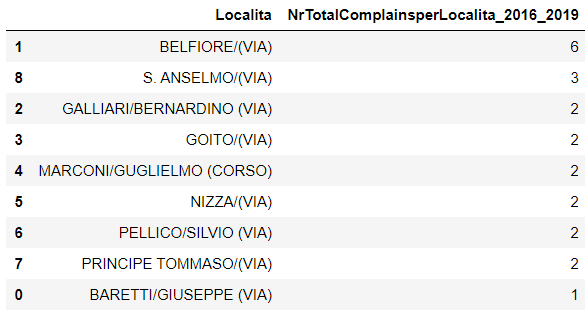

The table above shows the count of police complaints by San Salvario streets. Only complaints related to noisy situations. In total we have only 20. The volume of complaints is really low taking acount that we have an historic data of 4 years. 

### Police complaints prediction

It would be helpful for the police department to have some data tools which help it control extreme noise levels. With that intention we develope a complaints predictive model, based on a Random Forest Classifier to learn if a certain day there is a complain registered (Category = 1) or not (Category = 0) . 

Because no hour information is reported in the complain we are using all day information of the reported complain day, what is not the ideal when targeting a future prediction, but the main reason is to validate an initially infered correlation between  noise sensor data and noise complains (not shown here).

For that, we use information of the last 10 days from the date of the complain to calculate a baseline for the values of the sensors. We only pick the 10 days before in order to don't have a highly umbalanced data set (in 4 years (pre-covida data) only ca. 20 days have a reported complain!). The data used in the model is the number of times in a day the five sensors recorded data above the 75% quantile of the baseline noise values (higher noises). 

The model also takes into account the day of the week and the month of the report to predict complain in a certain day.



In [ ]:
#get dates of the complains
complains=list(SanSalv_rumori.Data) 
len(complains)

ahead_1=[]
previous_10=[]
for date in complains:
    ahead_1.append(str(date+timedelta(days=1))[:10])
    previous_10.append(str(date-timedelta(days=10))[:10])

def calculate_higherquantile(noise, previous_10, ahead_1, n):
    days_around_complain=noise.loc[(noise['Data']<=ahead_1[n]) & (noise['Data']>previous_10[n])][['Data','hour','dayofweek', 'C1','C2','C3','C4','C5']]
    descr=days_around_complain.describe()
    days_around_complain.loc[days_around_complain['C1']<descr.C1.loc['75%'], 'C1']= int(0)
    days_around_complain.loc[days_around_complain['C1']>=descr.C1.loc['75%'], 'C1']= int(1)
    days_around_complain.loc[days_around_complain['C2']<descr.C2.loc['75%'], 'C2']= int(0)
    days_around_complain.loc[days_around_complain['C2']>=descr.C2.loc['75%'], 'C2']= int(1)
    days_around_complain.loc[days_around_complain['C3']<descr.C3.loc['75%'], 'C3']= int(0)
    days_around_complain.loc[days_around_complain['C3']>=descr.C3.loc['75%'], 'C3']= int(1)
    days_around_complain.loc[days_around_complain['C4']<descr.C4.loc['75%'], 'C4']= int(0)
    days_around_complain.loc[days_around_complain['C4']>=descr.C4.loc['75%'], 'C4']= int(1)
    days_around_complain.loc[days_around_complain['C5']<descr.C5.loc['75%'], 'C5']= int(0)
    days_around_complain.loc[days_around_complain['C5']>=descr.C5.loc['75%'], 'C5']= int(1)
    
    return days_around_complain

#counts the number of times in a day and for each sensor noise was higher than the 75 quantile noise level in the 10 days before claim
days_around_complain_0=calculate_higherquantile(noise, previous_10,ahead_1, 0).groupby(['Data','dayofweek']).sum().reset_index().drop('hour', axis=1)
days_around_complain_1=calculate_higherquantile(noise, previous_10,ahead_1, 1).groupby(['Data','dayofweek']).sum().reset_index().drop('hour', axis=1)
days_around_complain_2=calculate_higherquantile(noise,previous_10, ahead_1, 2).groupby(['Data','dayofweek']).sum().reset_index().drop('hour', axis=1)
days_around_complain_3=calculate_higherquantile(noise,previous_10, ahead_1, 3).groupby(['Data','dayofweek']).sum().reset_index().drop('hour', axis=1)
days_around_complain_4=calculate_higherquantile(noise, previous_10,ahead_1, 4).groupby(['Data','dayofweek']).sum().reset_index().drop('hour', axis=1)
days_around_complain_5=calculate_higherquantile(noise, previous_10,ahead_1, 5).groupby(['Data','dayofweek']).sum().reset_index().drop('hour', axis=1)
days_around_complain_6=calculate_higherquantile(noise, previous_10,ahead_1, 6).groupby(['Data','dayofweek']).sum().reset_index().drop('hour', axis=1)
days_around_complain_7=calculate_higherquantile(noise, previous_10,ahead_1, 7).groupby(['Data','dayofweek']).sum().reset_index().drop('hour', axis=1)
days_around_complain_8=calculate_higherquantile(noise, previous_10,ahead_1, 8).groupby(['Data','dayofweek']).sum().reset_index().drop('hour', axis=1)
days_around_complain_9=calculate_higherquantile(noise, previous_10,ahead_1, 9).groupby(['Data','dayofweek']).sum().reset_index().drop('hour', axis=1)
days_around_complain_10=calculate_higherquantile(noise, previous_10,ahead_1, 10).groupby(['Data','dayofweek']).sum().reset_index().drop('hour', axis=1)
days_around_complain_11=calculate_higherquantile(noise, previous_10,ahead_1, 11).groupby(['Data','dayofweek']).sum().reset_index().drop('hour', axis=1)
days_around_complain_12=calculate_higherquantile(noise, previous_10,ahead_1, 12).groupby(['Data','dayofweek']).sum().reset_index().drop('hour', axis=1)
days_around_complain_13=calculate_higherquantile(noise, previous_10,ahead_1, 13).groupby(['Data','dayofweek']).sum().reset_index().drop('hour', axis=1)
days_around_complain_14=calculate_higherquantile(noise, previous_10,ahead_1, 14).groupby(['Data','dayofweek']).sum().reset_index().drop('hour', axis=1)

frames2=[days_around_complain_0, days_around_complain_1, days_around_complain_2, days_around_complain_3, days_around_complain_4,
        days_around_complain_5, days_around_complain_6, days_around_complain_7, days_around_complain_8, days_around_complain_9,
        days_around_complain_10, days_around_complain_11, days_around_complain_12, days_around_complain_13, days_around_complain_14]
alldays_around_complains=pd.concat(frames2)

mergedwithrumori=alldays_around_complains.merge(SanSalv_rumori, left_on='Data', right_on='Data', how='left')

finalNoisewithComplains=finalNoisewithComplains.drop(['Data', 'year'], axis=1)



In [ ]:
#there is not enough data to a train/test split and is just a preliminary approach
clf_RF = RandomForestClassifier(max_depth=5, random_state=0).fit(finalNoisewithComplains.iloc[:,:-1], finalNoisewithComplains.iloc[:,-1])
preds=clf_RF.predict(finalNoisewithComplains.iloc[:,:-1])

In [ ]:
finalNoisewithComplains['Predicted']=preds
finalNoisewithComplains[finalNoisewithComplains.Category==1]

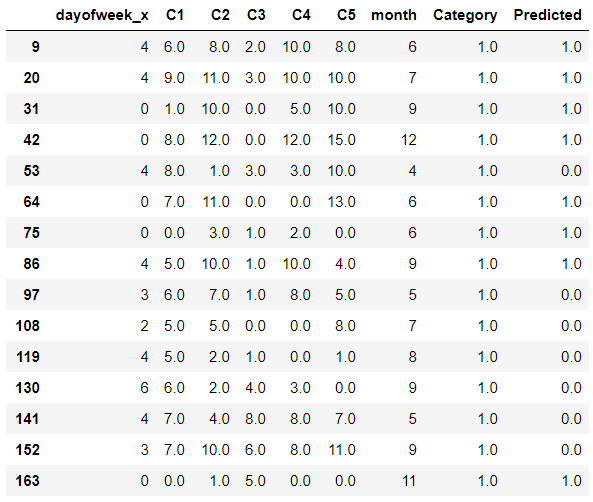

The main figures from the model are bearing in mind the quite limited data and conditions (no train/test split so some overfitting might also be present), it was obtained a recall of 53.3% (model indicated a police complain would be correctly predicted by the model in 5 out of each 10 cases, precision=100% (model did not predict false positives what is very good) and accuraccy is higher (96%) than a random guessing - for a 10% umbalanced dataset random guessing accuracy is 90%.

Moreover, it was observed some missing information from the noise sensors on the same relevant dates for the model dataset, so the count of highly noisy hours might be underestimated in some dates, so most probably model might be failing to predict positive complains on some of the dates because of the incorrect count of noise values above the 75% quantile for those dates.

Anyway this was just a possible approach for the model, other quantiles can be chosen depending on the skewness of the noise sensor data, also the previous number of days to use as baseline for the quantile can be adjusted, weather data can also be included, moreover complains coming from the police reporting should have hour indication of the claim, to better understand if it is a night complain or not, once there is almost no information about time of the police complains.

Also more sensors in the city might help predict police complains because indeed seems to there be a correlation, although more statistical analysis are required but this was not herein performed due to lack of time.

### Presence and Noise Pollution data analysis

Next graphic show us some relationship between the number of visitors and noise levels. Higher the visitors, higher the pollution. Especially when visitor presence is low there is not high noise levels. So, that make us wonder if there is already too much people concentration and then too much acustic pollution.  

Here is represented the information from 03/06/2020 to 10/06/2020. It was only take this week in order to follow the same logic with databases we will use next (SIM_count shows only information of these days in 2018).


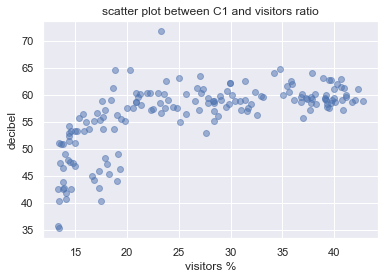

In [124]:
plt.scatter(noise_pres_202006['visitors_%'], noise_pres_202006['C1'], alpha=0.5)
plt.title('scatter plot between C1 and visitors ratio')
plt.xlabel('visitors %')
plt.ylabel('decibel')
plt.show()

Next, we demonstrate that there already exists a congestion situation is San Salvario streets. First of all, we define two areas: 1) Largo Saluzzo surrounding area and 2) the entire San Salvario neighborhood. On one hand we test if visitors concentration levels are different between the two areas, if there is one of them which have more people congestion. On the other hand, we find where noise pollution levels are higher


First test we do is about concentration. We have two samples, each one representing the people presence of each area, during the same week (different years because of available data; 2018 & 2020). 

Due to the difference between both size areas we have to relativize the presence. Also because data is collected from mobiles coverage, so residents look like people in the street "making noise", when may be they are at home. So, we carry out two transformations. We create visitors variable which is the total presence minus the residents. Then we calculate the ratio between visitors and presence (visitors_%). This visitors percentage is our dependant variable from which we will find the differences.


In [82]:
base3_201806 = base3[base3.index >='2018-06-03T22:00:00Z']#,'2018-06-10T21:00:00Z')]
base3_201806 = base3_201806[base3_201806.index <='2018-06-10T21:00:00Z']
base3_201806 = base3_201806.reset_index()
base3_201806['visitors'] = base3_201806['Presenze'] - base3_201806['Residenti']
base3_201806['visitors_%'] = (100 * base3_201806['visitors'] / base3_201806['Presenze']).round(2)

noise_pres_202006 = noise_presence[noise_presence['datefrom'] >='2020-06-03 22:00:00']#,'2018-06-10T21:00:00Z')]
noise_pres_202006 = noise_pres_202006[noise_pres_202006['datefrom'] <='2020-06-10 21:00:00']

Statistically, the best way to demonstrate that two sample are different between them is regarding the median of both populations. The most robust test is through an ANOVA, but firstly we have to test homocedasticity and normality. 

In [83]:
# Levene test -- Data Homocedasticity
stat, p = levene(base3_201806['visitors_%'], noise_pres_202006['visitors_%'])
if p < 0.05:
    print("p-value = ", p, "; There is not homocedasticity")
else:
    print("p-value = ", p, "; There is homocedasticity")

p-value =  0.0009194713338162683 ; There is not homocedasticity


In [98]:
# Shapiro-Wilk test -- Data Normality
shapiro_test = shapiro(pd.concat([base3_201806['visitors_%'],noise_pres_202006['visitors_%']], axis = 0))
if shapiro_test[1] < 0.05:
    print("p-value = ", shapiro_test[1], "; Our data have not a Normal distribution")
else:
    print("p-value = ", shapiro_test[1], "; Our data have not a Normal distribution")

p-value =  1.499359036927217e-08 ; Our data have not a Normal distribution


As we see above for the visitors test there is not neither homocedasticity nor normality (both p-values are too low, so we refuse null hypothesis of constant variance and normality). So, we have to test through a non-parametric model test.

Since we have two samples a U-Mann Whitney test should be enough. The main adventage of this test is that they don't need normality nor homocedasticity. The UMW tests if median of both samples are equal (H0) or not (H1). 

The test returns us a p-value lower than 0.05, so we can refuse that medians are equal, so there are significative differences between visitors concentration levels between the two areas.

In [120]:
stat, p = mannwhitneyu(base3_201806['visitors_%'], noise_pres_202006['visitors_%'])
print("stat = ", stat, " p-value = ", p)


stat =  5797.0  p-value =  4.859946934191554e-21


In order to know which of both samples has higher median (once we know they are different), we analyse their distributions. We can see in the table below that concentration in Largo Saluzzo is higher. The 25% of the less concentrated time lapses in Largo Saluzzo are at list occupied for a 29% of visitors (of total presence), meanwhile in the rest of San Salvario neighborhood only 17%.  

In [86]:
descriptivo1 = base3_201806['visitors_%'].describe()
descriptivo1 = pd.DataFrame(descriptivo1[descriptivo1.index.isin(['25%','50%','75%'])])
descriptivo1.columns = ['Largo Saluzzo']

descriptivo2 = noise_pres_202006['visitors_%'].describe()
descriptivo2 = pd.DataFrame(descriptivo2[descriptivo2.index.isin(['25%','50%','75%'])])
descriptivo2.columns = ['San Salvario']

descriptivo = pd.concat([descriptivo1,descriptivo2], axis = 1)
descriptivo

,Largo Saluzzo,San Salvario
25%,29.5225,17.6075
50%,39.3400,25.6800
75%,52.4600,35.8325


After demonstrate that people concentration is higher in Largo Saluzzo, we analyse if there is also more noise pollution. 

For that we match noise levels from two sensors, C2 and C3. First one, is in "Via Principe Tommaso" so outside of Largo Saluzzo area of influence. C3 is exactly at Largo Saluzzo. The goal is to find differences between both data and then analyse if C3 levels are higher, since as this area is more concentrated.

The statistical technique is the same, we test difference between both samples medians. We start again testing homocedasticity and normality, in order to try to apply an ANOVA. 

Watching the results,normality conditions it is not achieved, so again we test through an U-Mann Whitney.

In [118]:
# Levene test -- Data Homocedasticity
stat, p = levene(noise_pres_202006['C2'], noise_pres_202006['C3'])
if p < 0.05:
    print("p-value = ", p, "; There is not homocedasticity")
else:
    print("p-value = ", p, "; There is homocedasticity")

p-value =  0.9060938116431715 ; There is homocedasticity


In [119]:
# Shapiro-Wilk test -- Data Normality
shapiro_test = shapiro(pd.concat([noise_pres_202006['C2'],noise_pres_202006['C3']], axis = 0))
if shapiro_test[1] < 0.05:
    print("p-value = ", shapiro_test[1], "; Our data have not a Normal distribution")
else:
    print("p-value = ", shapiro_test[1], "; Our data have not a Normal distribution")

p-value =  3.891910012043809e-07 ; Our data have not a Normal distribution


Next, the U-Mann Whitney test. We find statistical differences between both sensors levels, since as p-value is lower than 0.05

In [125]:
stat, p = mannwhitneyu(noise_pres_202006['C2'], noise_pres_202006['C3'])
print("stat = ", stat, " p-value = ", p)


stat =  11860.5  p-value =  0.005727428604139367


Finally, analysing the distribution table below, we conclude that Largo Saluzzo is noisier than the other areas of San Salvario.

Both demonstrations allow us conclude that higher the visitors concentration higher the noise pollution. The goal of this research line was exactly to find these differences and conclude that one of the possible solutions to environmental noise is to look for a better people distribution in the streets, that's to better manager the localisation of areas of interest of people, such as bar, restaurants, shops... 

In [122]:
descriptivo1 = noise_pres_202006['C2'].describe()
descriptivo1 = pd.DataFrame(descriptivo1[descriptivo1.index.isin(['25%','50%','75%'])])
descriptivo1.columns = ['San Salvario']

descriptivo2 = noise_pres_202006['C3'].describe()
descriptivo2 = pd.DataFrame(descriptivo2[descriptivo2.index.isin(['25%','50%','75%'])])
descriptivo2.columns = ['Largo Saluzzo']

descriptivo = pd.concat([descriptivo1,descriptivo2], axis = 1)
descriptivo

,San Salvario,Largo Saluzzo
25%,52.075,54.400
50%,57.600,58.800
75%,60.000,61.925


### Conclusions and Proposals

The main issue we have found building this repository it was data quality. Due to different reasons, lost of noise sensor  information may be caused machine failures. Presence data were only available some weeks, we didn't have enough data to make good moblity predictions. Also police complaints had some missing information.

As we see, all of these problems had different reasons but the same consequencies: difficulty to data scientist to work with. For that, some of our proposals head toward improve the data mining systems and become policy makers aware of importance of data analysis, in order to improve social problems (currents and futures).

We would like to emphisize in sensors failures and police implication. First one, because having several missing values during continuous weeks, can throw away the work of months and of a lot of people. On second term, we request the police department to make an effort on input data in their systems, with the goal of can build a robust claims predictive model, and then really could help them from the data teams.

Our second proposal is related to first one in some senses, if we had enough data and then a good strategy, we could carry out the next proposals suported by statistical methods:

 - Now we are not concious about the noise we produce and the disruptions we provoke to the neighbours, but what if we would know? We are sure that knowledge encourage people. For that we propose a Public Open Data Dashboard, publishing the noise information every day, with special regarding on these days in which noise achieve high levels. Since this is open and public, we will reaching every one, making us aware of the situation.  
 
 - Dashboard should be available for bussines owners, including the predictive model. Knowing complaints and noise predictions they could prevent their schedules and advise their clients.
 
 - Triangulation between sensors. The goal of this proposal is to create alarm areas. If there are several close sensors reaching high noise levels during some continuous peaks or moments, this area could be marked as Yellow Flag, so police could act advertising the people and night locals owners, warming them of possible sanctions. If problems continue during several days Yellow Flag will become Red, and then sanctions and other actions could be carried out.
 
 
The main advantages of these actions are:

 - Business owners can request their clients to be aware of noise levels to avoid problems for both parts.
 
 - Clients would understand the importance of do not disturb with their conversations, shouting and quarrels. Including the importance of maintaining their future scheduled night plans, which could be cancelled by their own noise.
 
 - Complainers also would know that their complains would be accounted for.


As we have seen in the Presence and Noise analysis there exist a positive relationship between the number of visitors and the noise levels. When area receives more visitors then sounds sensors detect more dB. So, one solution to reduce the noise is to avoid massive people concentrations. The best way to achieve this target is by redistributing the main points of interest of the  visitors, such as bars & restaurants and alimentary & drinking shops. Also by not allowing every appartment in the historic center become turistic.

Others solutions to the environmental noise are the installation of soundproof windows. Residents should be suported by statal subvencions. 


#### Authors

BelManuel Soto Team:

 - Beltran Vazquez Liniers
 - Lucia Morerira